## Import des lib

In [9]:
import csv
import os
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union

from torch.utils.data import Dataset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchaudio.transforms import MelSpectrogram
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset
### Création d'un custom dataset pour les données audio qui permette de convertir les fichiers audio en en waveform
Documentation Pytorch pour le dataset Common Voice de Mozilla adapté pour le format du dataset segment word

In [10]:
def load_commonvoice_item(
    line: List[str], header: List[str], path: str, folder_audio: str, ext_audio: str
) -> Tuple[Tensor, int, Dict[str, str]]:
    # Each line as the following data:
    # client_id, path, sentence, up_votes, down_votes, age, gender, accent

    if header[1] != "path":
        raise ValueError(f"expect `header[1]` to be 'path', but got {header[1]}")
    fileid = line[1]
    filename = os.path.join(path, folder_audio, fileid)
    if not filename.endswith(ext_audio):
        filename += ext_audio
    waveform, sample_rate = torchaudio.load(filename)

    dic = dict(zip(header, line))
    return waveform, sample_rate, dic

class COMMONVOICE(Dataset):
    _ext_audio = ".mp3"
    _folder_audio = "clips"

    def __init__(self, root: Union[str, Path], tsv: str = "train.tsv", transform=None):
        self._path = os.fspath(root)
        self._tsv = os.path.join(self._path, tsv)
        with open(self._tsv, "r") as tsv_:
            walker = csv.reader(tsv_, delimiter="\t")
            self._header = next(walker)
            self._walker = [row for row in walker if row[self._header.index('sentence')] not in  ['Hey','Firefox','zéro','cinq','six','sept','huit','neuf', 'oui','non']]
        self.transform = transform or MelSpectrogram()

    def __getitem__(self, n: int) -> Tuple[torch.Tensor, str]:
        line = self._walker[n]
        waveform, _, dic = load_commonvoice_item(line, self._header, self._path, self._folder_audio, self._ext_audio)
        spectrogram = self.transform(waveform).squeeze(0)  # Apply transformation and remove channel dim
        label = dic["sentence"]
        return spectrogram, label

    def __len__(self) -> int:
        return len(self._walker)


transform = MelSpectrogram(sample_rate=48000, n_mels=128, n_fft=1024, hop_length=128)

train_dataset = COMMONVOICE(root="./data/cv-corpus-7.0-singleword/fr", tsv="train.tsv", transform=transform)
test_dataset = COMMONVOICE(root="./data/cv-corpus-7.0-singleword/fr", tsv="test.tsv", transform=transform)


## Création d'un modèle simple de convolution
> 
> - C16K3S1P1
> - Maxpool
> - C32K3S1P1
> - Maxpool
> - Flatten
> - FC128
> - ReLU
> - FC10
> - Softmax (Compris dans Adam)
> 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7812, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)  
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Mapping
- Mapping des labels sur des valeurs numériques

In [12]:
import torch

map_test = {
    'un': 0,
    'deux': 1,
    'trois': 2,
    'quatre': 3,
    # 'oui': 4,
    # 'non': 5,
}

- Parcours à travers les dataset pour trouver la plus grand valeur de time frame pour ensuite pad
- Définition de la fonction collate_fn qui est un arg lors de la création d'un dataloader et qui va prendre chaque batch et le transformer (Ici pour effectuer du padding et mapper les labels)


In [13]:
max_length_train = 0
max_length_test = 0

# for index in range(len(train_dataset)):
#     spectrogram, label = train_dataset[index]
#     if spectrogram.shape[-1] > max_length_train:
#         max_length_train = spectrogram.shape[-1]

# for index in range(len(test_dataset)):
#     spectrogram, label = test_dataset[index]
#     if spectrogram.shape[-1] > max_length_test:
#         max_length_test = spectrogram.shape[-1]

def collate_fn(batch):
    spectrograms, labels = zip(*batch)
    max_length = 1011
    padded_specs = [F.pad(spec, (0, max_length - spec.shape[-1])) for spec in spectrograms]
    spectrograms_padded = torch.stack(padded_specs)
    labels = torch.tensor([map_test[label] for label in labels], dtype=torch.long)
    return spectrograms_padded, labels


train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,drop_last=True)
test_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,drop_last=True)


model = SimpleCNN(num_classes=4)


# print(max_length_train)
# print(max_length_test)


## Useless 
Affichage d'un spectrogram 

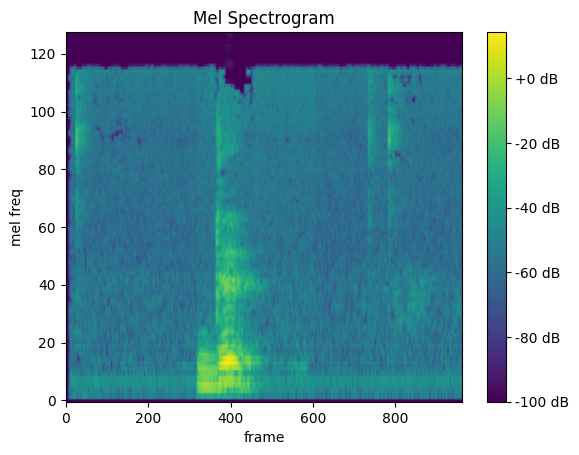

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
def plot_spectrogram(spectrogram, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    """
    Plots a spectrogram.
    
    Parameters:
        spectrogram (Tensor): A spectrogram with shape [Frequency, Time].
        title (str, optional): Title of the plot.
        ylabel (str, optional): Label of the y-axis.
        aspect (str, optional): Aspect ratio of the plot.
        xmax (int, optional): Maximum value of the x-axis.
    """
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (dB)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spectrogram, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    axs.set_yscale('linear')
    fig.colorbar(im, ax=axs, format="%+2.0f dB")
    plt.show(block=False)

spectrogram_db = torchaudio.transforms.AmplitudeToDB()(train_dataset[6][0])
plot_spectrogram(spectrogram_db.numpy(), title='Mel Spectrogram', ylabel='mel freq')


## Entrainement

In [15]:
def train(model, train_data_loader, optimizer, criterion):
    model.train()
    for epoch in range(5):
        for batch_idx, (spectrograms, labels) in enumerate(train_data_loader):
            optimizer.zero_grad()
            outputs = model(torchaudio.transforms.AmplitudeToDB()(spectrograms))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}: Loss: {loss.item()}")
        
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() 
train(model, train_data_loader, optimizer, criterion)

Epoch 1: Loss: 1.3935136795043945
Epoch 2: Loss: 1.3894439935684204
Epoch 3: Loss: 1.3898006677627563
Epoch 4: Loss: 1.3908991813659668
Epoch 5: Loss: 1.3878225088119507


## Évaluation

In [16]:
def test(model, test_data_loader):
    acc_total = 0
    model.eval()
    for spectrograms, labels in test_data_loader:
        outputs = model(spectrograms)
        _, predicted = torch.max(outputs, 1)
        acc_total += (predicted==labels).sum().item()/len(labels)
    print(f"Accuracy: {acc_total/len(test_data_loader)}")

test(model, test_data_loader)

Accuracy: 0.2512175324675325
